## Importing Libraries and data

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-02-27 08:56:39.559626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tf.__version__)
############ settings ############
data_dir = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data"


batch_size = 32
img_height = 128
img_width = 128

2.11.0


## Splitting data

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.


2023-02-27 09:02:00.534389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2152 files belonging to 3 classes.
Using 430 files for validation.


## Some EDA

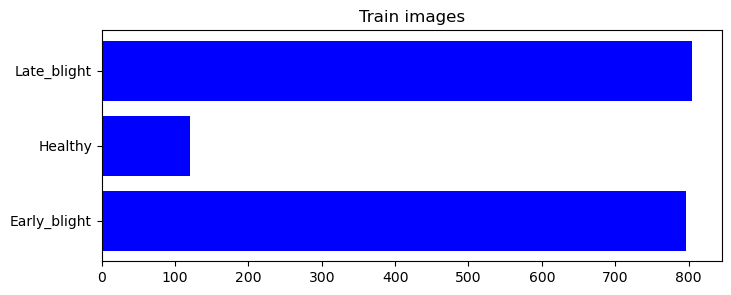

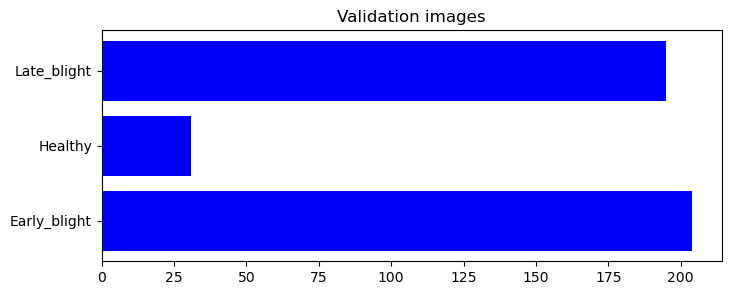

In [6]:
def plot_distribution(y, title):
    a = Counter(y)
    y = ['Early_blight', 'Healthy', 'Late_blight']
    
    x = [a[i] for i in range(3)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='blue')
    plt.title(title)
    return plt.show()

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")

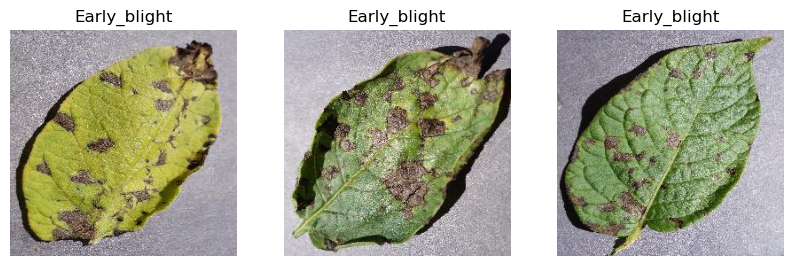

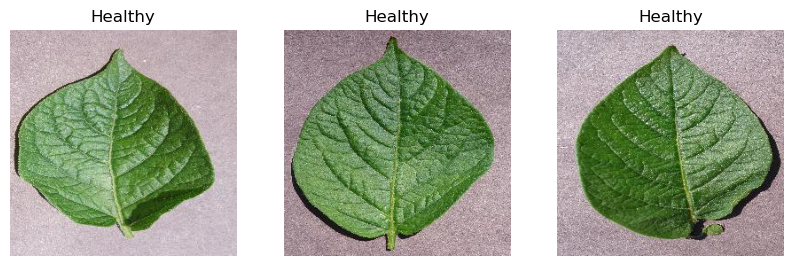

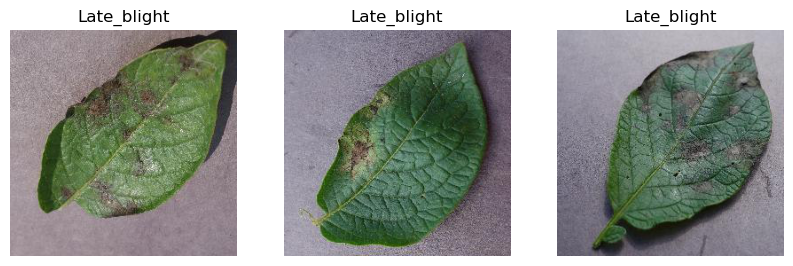

In [7]:
## Sample images
class_names = train_ds.class_names

for class_name in class_names:
    imgs = os.listdir(os.path.join(data_dir, class_name))[:3]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

# Modeling

In [8]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
#Model Architecture - preparing our model

num_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    # Rescaling will be helpful in deployment, as raw images will be rescaled within the model
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')

])

# Model Training

# Optimizer used is adam 

# Used 20 epochs

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[earlystop_callback])

Epoch 1/20
54/54 [==============================] - 26s 435ms/step - loss: 0.8171 - accuracy: 0.6074 - val_loss: 0.5325 - val_accuracy: 0.8116
Epoch 2/20
54/54 [==============================] - 23s 421ms/step - loss: 0.4442 - accuracy: 0.8345 - val_loss: 0.3114 - val_accuracy: 0.8651
Epoch 3/20
54/54 [==============================] - 22s 414ms/step - loss: 0.3026 - accuracy: 0.8897 - val_loss: 0.2280 - val_accuracy: 0.9000
Epoch 4/20
54/54 [==============================] - 23s 430ms/step - loss: 0.2325 - accuracy: 0.9141 - val_loss: 0.2705 - val_accuracy: 0.8907
Epoch 5/20
54/54 [==============================] - 23s 424ms/step - loss: 0.2132 - accuracy: 0.9210 - val_loss: 0.1701 - val_accuracy: 0.9442
Epoch 6/20
54/54 [==============================] - 23s 425ms/step - loss: 0.1687 - accuracy: 0.9379 - val_loss: 0.2054 - val_accuracy: 0.9302
Epoch 7/20
54/54 [==============================] - 23s 434ms/step - loss: 0.1296 - accuracy: 0.9553 - val_loss: 0.1681 - val_accuracy: 0.9326

The model has a 98% Training accuracy and a 96% Validation accuracy

# Validation

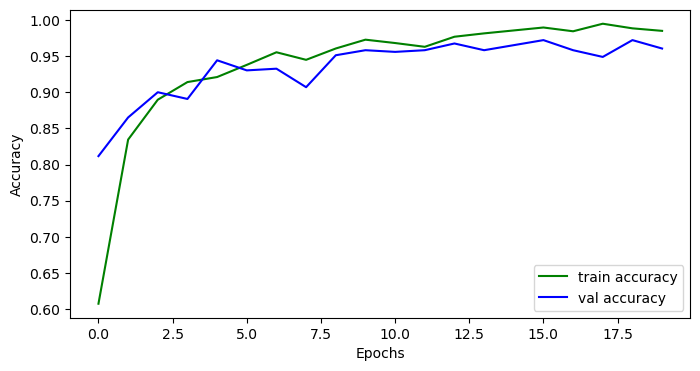

In [13]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



As seen, the training accuracy started off at 60% accuracy and gradually improved, and stabilized at 98%.

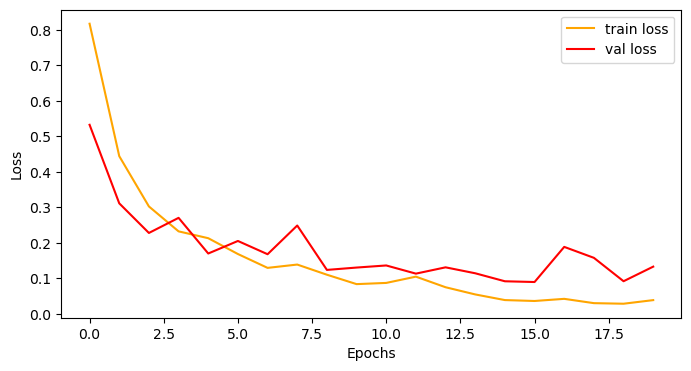

In [12]:
# loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

the opposite effect is witness with the loss function, as a low loss function illustrates great performance without overfitting.

In [16]:
# Accuracy, F1 score and precision score

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

#Classification Report



1/1 [==============================] - 0s 121ms/step


In [17]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       204
           1       0.86      0.97      0.91        31
           2       0.97      0.94      0.96       195

    accuracy                           0.96       430
   macro avg       0.93      0.96      0.95       430
weighted avg       0.96      0.96      0.96       430



The model is performing well. details will be in the report

## Model Extraction and Testing

In [19]:
# saving the model 

model.save("/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/model_v1.h5")

In [20]:
# Function that inputs a raw image and predicts whether it is early blight, late blight or healthy...and how accurate it is

def prediction(img):
    class_names = ['Early_blight', 'Healthy', 'Late_blight']

    my_image = load_img(img, target_size=(img_height, img_width))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

### Healthy

1/1 [==============================] - 0s 78ms/step


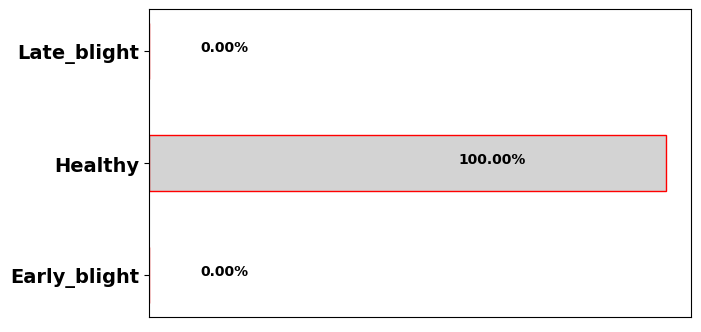

In [21]:
# Predicting a healthy image

image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG"
prediction(image)

1/1 [==============================] - 0s 60ms/step


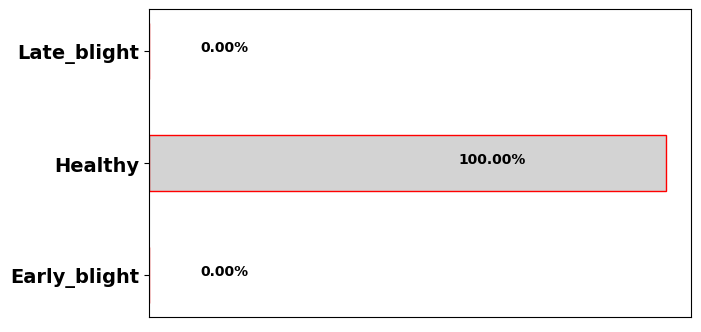

In [22]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Healthy/3edf7c3f-73e0-439c-870d-76cfd7c3bc45___RS_HL 1859.JPG"
prediction(image)

1/1 [==============================] - 0s 52ms/step


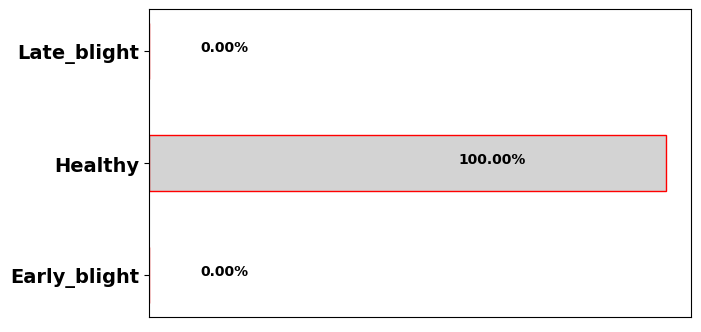

In [23]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Healthy/dbe4f332-9189-4b76-b30c-f0c9a55e48d3___RS_HL 1841.JPG"
prediction(image)

### Early Blight

1/1 [==============================] - 0s 71ms/step


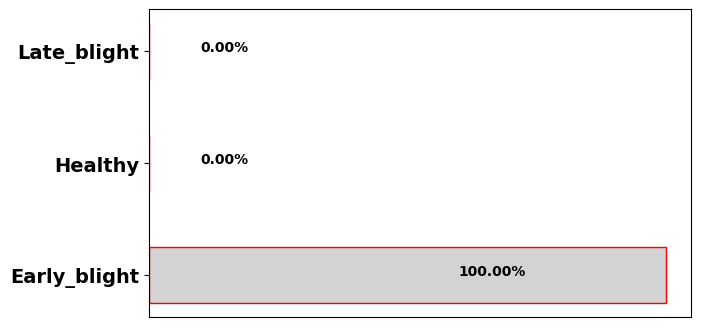

In [24]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Early_blight/0d2e2971-f1c9-4278-b35c-91dd8a22a64d___RS_Early.B 7581.JPG"
prediction(image)

1/1 [==============================] - 0s 69ms/step


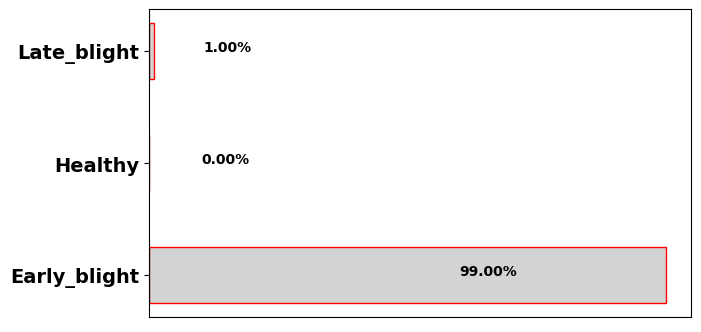

In [28]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Early_blight/2cc3eb24-b210-4827-befe-0e3a24161ac4___RS_Early.B 6829.JPG"
prediction(image)

1/1 [==============================] - 0s 85ms/step


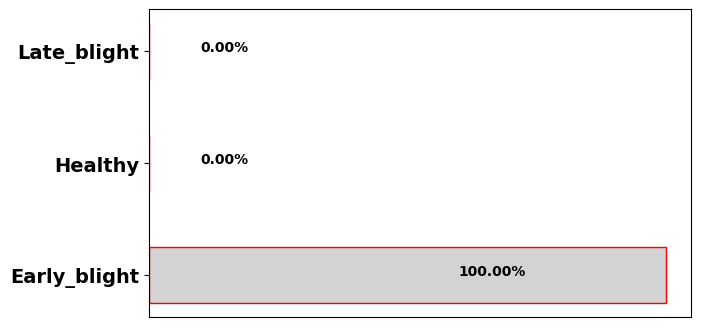

In [30]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Early_blight/4c7622da-663c-48df-8005-355fff221fe1___RS_Early.B 8432.JPG"
prediction(image)

### Late Blight

1/1 [==============================] - 0s 56ms/step


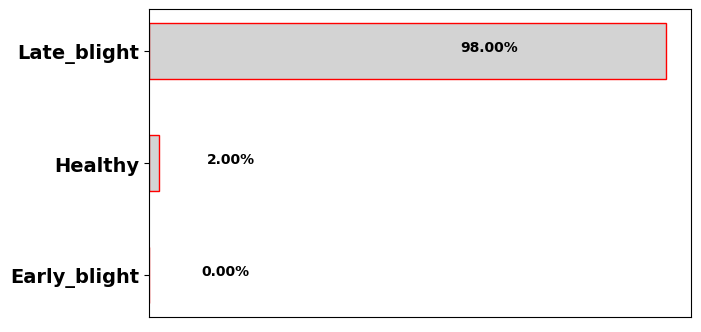

In [31]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Late_blight/0e7f0484-16eb-4183-b702-0a5b4f94d015___RS_LB 4000.JPG"
prediction(image)

1/1 [==============================] - 0s 82ms/step


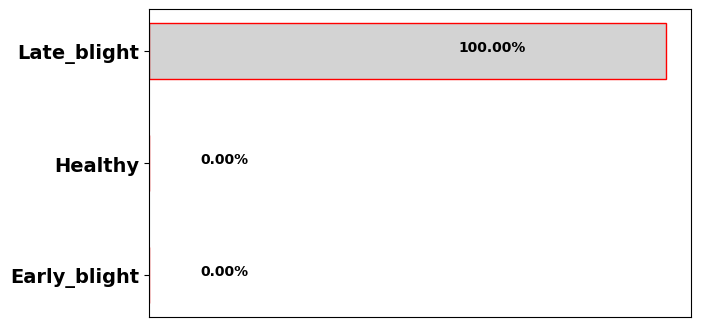

In [32]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Late_blight/1a674846-9d13-4a7f-ba03-8931c5dd3d2c___RS_LB 2768.JPG"
prediction(image)

1/1 [==============================] - 0s 69ms/step


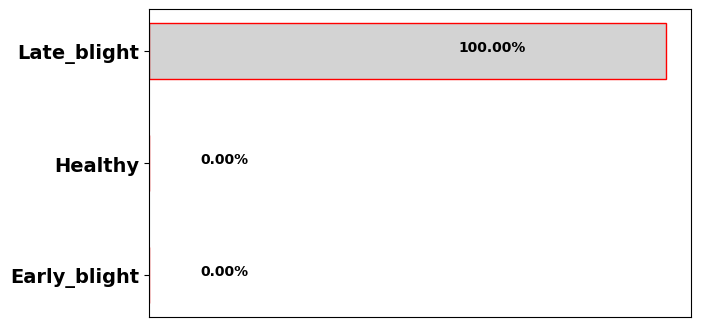

In [33]:
image = "/Users/RyanMburu/Desktop/4th Year Project/Waru Bora/Machine Learning/data/Late_blight/2c33381e-78d8-47fc-8cea-1459164f46d6___RS_LB 4115.JPG"
prediction(image)